In [1]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from tensorflow.keras.layers import Input,Dense,Reshape,Conv2D,Dropout,multiply,Dot,Concatenate,subtract,ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization,LeakyReLU,Flatten
from tensorflow.keras.layers import Conv2DTranspose as Deconv2d
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras import backend as K
import smtplib

from sklearn.utils import shuffle
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import re
from tensorflow.keras.preprocessing.image import img_to_array
import random
from tensorflow.keras.models import load_model

In [15]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 128
color_img = []
path = r'/kaggle/input/image-colorization/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
        if i == '2200.jpg':
            break
        else:
            img = cv2.imread(path + '/'+i,1)
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            color_img.append(img_to_array(img))


gray_img = []
path = r'/kaggle/input/image-colorization/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
         if i == '2200.jpg':
            break
         else:
            img = cv2.imread(path + '/'+i,1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            gray_img.append(img_to_array(img))

100%|██████████| 12868/12868 [01:58<00:00, 108.29it/s]


In [17]:
color_dataset=tf.data.Dataset.from_tensor_slices(np.array(color_img))
gray_dataset=tf.data.Dataset.from_tensor_slices(np.array(gray_img))

# MODELING

In [18]:
def downsample(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer='he_normal', use_bias=not apply_batchnorm))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())
    return result


def upsample(filters, size, apply_dropout=False):

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())
  return result

# Generator

In [19]:
import tensorflow as tf

# Giả sử các hàm downsample và upsample đã được định nghĩa
# downsample(filters, size, apply_batchnorm=True)
# upsample(filters, size, apply_dropout=False)

def Generator():
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # ✅ Downsampling (giảm 1 tầng và số filters để giảm tham số)
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (64, 64, 64)
        downsample(128, 4),  # (32, 32, 128)
        downsample(256, 4),  # (16, 16, 256)
        downsample(384, 4),  # (8, 8, 384)  ✅ Giảm filters từ 512 -> 384
        downsample(384, 4),  # (4, 4, 384)
        downsample(512, 4),  # (2, 2, 512)  ✅ Giữ 512 ở mức thấp nhất
    ]

    # ✅ Upsampling (giảm filters ở các tầng trên)
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (4, 4, 512)
        upsample(384, 4, apply_dropout=True),  # (8, 8, 384)  ✅ Giảm filters
        upsample(256, 4),  # (16, 16, 256)
        upsample(128, 4),  # (32, 32, 128)
        upsample(64, 4),   # (64, 64, 64)
        upsample(32, 4),   # (128, 128, 32)
    ]

    # ✅ Dùng SeparableConv2D thay cho Conv2D để giảm tham số
    last = tf.keras.layers.SeparableConv2D(3, kernel_size=3, strides=1, padding='same', activation='tanh')

    x = inputs
    skips = []

    # Downsampling với skip connections
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])  # Bỏ tầng cuối cùng

    # Upsampling với skip connections
    for up, skip in zip(up_stack[:-1], skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # Tầng upsample cuối cùng không có skip connection
    x = up_stack[-1](x)

    # Tầng đầu ra
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

# Kiểm tra mô hình
generator = Generator()
generator.summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 64, 64, 64)     │          3,136 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 32, 32, 128)    │        131,584 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 16, 16, 256)    │        525,312 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 8, 8, 384)      │      1,574,400 │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 4, 4, 384)      │      2,360,832 │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 2, 2, 512)      │      3,147,776 │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_6 (Sequential) │ (None, 4, 4, 512)      │      4,196,352 │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 4, 4, 896)      │              0 │ sequential_6[0][0],    │
│                           │                        │                │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, 8, 8, 384)      │      5,506,560 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 8, 8, 768)      │              0 │ sequential_7[0][0],    │
│ (Concatenate)             │                        │                │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_8 (Sequential) │ (None, 16, 16, 256)    │      3,146,752 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 16, 16, 512)    │              0 │ sequential_8[0][0],    │
│ (Concatenate)             │                        │                │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_9 (Sequential) │ (None, 32, 32, 128)    │      1,049,088 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 32, 32, 256)    │              0 │ sequential_9[0][0],    │
│ (Concatenate)             │                        │                │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_10             │ (None, 64, 64, 64)     │        262,400 │ concatenate_3[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4        

 Total params: 21,970,243 (83.81 MB)

 Trainable params: 21,964,163 (83.79 MB)

 Non-trainable params: 6,080 (23.75 KB)

# Discriminator

In [7]:
import tensorflow as tf

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[128, 128, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[128, 128, 3], name='target_image')

    x = tf.keras.layers.Concatenate()([inp, tar])  # (bs, 128, 128, 6)

    down1 = downsample(64, 4, apply_batchnorm=False)(x)   # (bs, 64, 64, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 32, 32, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 16, 16, 256)
    down4 = downsample(512, 4)(down3)  # (bs, 8, 8, 512)
    down5 = downsample(512, 4)(down4)  # (bs, 4, 4, 512)
    down6 = downsample(512, 4)(down5)  # (bs, 2, 2, 512) ✅

    conv = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same',
                                  kernel_initializer=initializer, use_bias=False)(down6)  # (bs, 2, 2, 512)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    last = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same',
                                  kernel_initializer=initializer)(leaky_relu)  # (bs, 2, 2, 1) ✅

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

# Test model
discriminator = Discriminator()
discriminator.summary()


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ target_image (InputLayer) │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 128, 128, 6)    │              0 │ input_image[0][0],     │
│ (Concatenate)             │                        │                │ target_image[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_12             │ (None, 64, 64, 64)     │          6,144 │ concatenate_5[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_13             │ (None, 32, 32, 128)    │        131,584 │ sequential_12[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_14             │ (None, 16, 16, 256)    │        525,312 │ sequential_13[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_15             │ (None, 8, 8, 512)      │      2,099,200 │ sequential_14[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_16             │ (None, 4, 4, 512)      │      4,196,352 │ sequential_15[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_17             │ (None, 2, 2, 512)      │      4,196,352 │ sequential_16[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 2, 2, 512)      │      4,194,304 │ sequential_17[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 2, 2, 512)      │          2,048 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_12            │ (None, 2, 2, 512)      │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 2, 2, 1)        │          8,193 │ leaky_re_lu_12[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,359,489 (58.59 MB)

 Trainable params: 15,354,625 (58.57 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [8]:
disc = Discriminator()
sample_input = tf.random.normal([1, 128, 128, 3])
sample_target = tf.random.normal([1, 128, 128, 3])
output = disc([sample_input, sample_target])
print(f"Discriminator output shape: {output.shape}")

Discriminator output shape: (1, 2, 2, 1)


# Check Loss

In [9]:
genLoss=[]
discLoss=[]

In [10]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  # Giữ nguyên
discriminator_optimizer = tf.keras.optimizers.Adam(7e-5, beta_1=0.5, weight_decay=1e-4)

LAMBDA = 150

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  genLoss.append(total_gen_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss
  discLoss.append(total_disc_loss)

  return total_disc_loss

# Training Method

In [11]:
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        # Đảm bảo gen_output có shape giống target
        gen_output = tf.image.resize(gen_output, (128, 128))
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss  # ✅ Trả về loss



# Fitting Method

In [12]:
import time

def fit(train_ds, epochs):
    history = {'gen_loss': [], 'gen_gan_loss': [], 'gen_l1_loss': [], 'disc_loss': []}

    for epoch in range(epochs):
        start = time.time()
        total_gen_loss, total_gan_loss, total_l1_loss, total_disc_loss = 0, 0, 0, 0
        num_batches = 0

        print("Epoch:", epoch+1)
        for n, (input_image, target) in train_ds.enumerate():
            gen_loss, gan_loss, l1_loss, disc_loss = train_step(input_image, target, epoch)

            total_gen_loss += gen_loss.numpy()
            total_gan_loss += gan_loss.numpy()
            total_l1_loss += l1_loss.numpy()
            total_disc_loss += disc_loss.numpy()
            num_batches += 1

        avg_gen_loss = total_gen_loss / num_batches
        avg_gan_loss = total_gan_loss / num_batches
        avg_l1_loss = total_l1_loss / num_batches
        avg_disc_loss = total_disc_loss / num_batches

        history['gen_loss'].append(avg_gen_loss)
        history['gen_gan_loss'].append(avg_gan_loss)
        history['gen_l1_loss'].append(avg_l1_loss)
        history['disc_loss'].append(avg_disc_loss)

        print(f"Epoch {epoch+1}: Gen Loss: {avg_gen_loss:.4f}, GAN Loss: {avg_gan_loss:.4f}, L1 Loss: {avg_l1_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}")
        print(f"Time taken for epoch {epoch+1} is {time.time()-start:.2f} sec\n")

        # Lưu trọng số mỗi 5 epoch
        if (epoch + 1) % 5 == 0:
            generator.save(f'generator_epoch_{epoch+1}.weights.h5')
            discriminator.save(f'discriminator_epoch_{epoch+1}.weights.h5')
            print(f"Đã lưu trọng số tại Epoch {epoch+1}")

    return history


# Fitting in 20 Epoch

In [13]:
BATCH_SIZE = 16
train_dataset = tf.data.Dataset.zip((
    gray_dataset.batch(BATCH_SIZE),
    color_dataset.batch(BATCH_SIZE)
))#.shuffle(1000)  # Shuffle để tránh overfitting

In [14]:
for input_image, target in train_dataset.take(1):  # Lấy 1 batch đầu tiên
    print("Input shape:", input_image.shape)
    print("Target shape:", target.shape)

Input shape: (16, 128, 128, 3)
Target shape: (16, 128, 128, 3)


In [15]:
hist = fit(train_dataset, epochs=20)
hist  


Epoch: 1
Epoch 1: Gen Loss: 16.9552, GAN Loss: 2.3552, L1 Loss: 0.0973, Disc Loss: 0.7243
Time taken for epoch 1 is 530.86 sec

Epoch: 2
Epoch 2: Gen Loss: 15.5090, GAN Loss: 6.3597, L1 Loss: 0.0610, Disc Loss: 0.0539
Time taken for epoch 2 is 522.37 sec

Epoch: 3
Epoch 4: Gen Loss: 10.8357, GAN Loss: 1.4921, L1 Loss: 0.0623, Disc Loss: 0.9376
Time taken for epoch 4 is 519.19 sec

Epoch: 5
Epoch 5: Gen Loss: 10.7465, GAN Loss: 1.8923, L1 Loss: 0.0590, Disc Loss: 0.8990
Time taken for epoch 5 is 520.60 sec

Đã lưu trọng số tại Epoch 5
Epoch: 6
Epoch 6: Gen Loss: 11.5857, GAN Loss: 2.9101, L1 Loss: 0.0578, Disc Loss: 0.4711
Time taken for epoch 6 is 519.64 sec

Epoch: 7
Epoch 7: Gen Loss: 13.6343, GAN Loss: 5.4150, L1 Loss: 0.0548, Disc Loss: 0.0577
Time taken for epoch 7 is 518.19 sec

Epoch: 8
Epoch 8: Gen Loss: 14.8927, GAN Loss: 6.9559, L1 Loss: 0.0529, Disc Loss: 0.0015
Time taken for epoch 8 is 517.30 sec

Epoch: 9
Epoch 9: Gen Loss: 15.3354, GAN Loss: 7.7629, L1 Loss: 0.0505, Disc

{'gen_loss': [16.955174725692466,
  15.508954466351812,
  10.49267274903955,
  10.835739462123895,
  10.746507841311626,
  11.585680584285571,
  13.634315055941943,
  14.892663159577744,
  15.335366204066306,
  15.853793590853673,
  16.110444100895283,
  16.485661672509234,
  16.77737312672301,
  16.919354060866077,
  17.263530298789835,
  17.49692235674177,
  17.738282170503037,
  18.08280147054921,
  15.869461578463916,
  7.570264980955894],
 'gen_gan_loss': [2.3552404580094057,
  6.359680977371168,
  1.170897886601294,
  1.4921457902106068,
  1.8923109202425903,
  2.910055585862687,
  5.414983503557511,
  6.955917020169845,
  7.762889602613745,
  8.27394548913707,
  8.726448168073382,
  9.186613511743012,
  9.633502244653169,
  10.022684674233384,
  10.454328707582462,
  10.860279121161987,
  11.267156536978964,
  11.672861502037286,
  9.585526865905857,
  1.1097666535017467],
 'gen_l1_loss': [0.09733289485299809,
  0.06099515667428141,
  0.06214516586305932,
  0.06229062447821872,


In [35]:
#generator.save_weights(f'generator_epoch_{epochs+1}.h5')
#discriminator.save_weights(f'discriminator_epoch_{epochs+1}.h5')


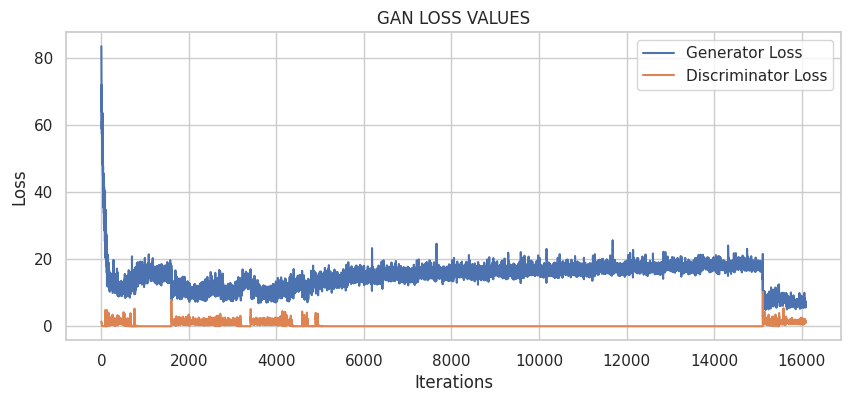

In [28]:
import seaborn as sns
sns.set(style='whitegrid')
plt.figure(figsize=(10,4))
plt.plot(genLoss, label="Generator Loss")
plt.plot(discLoss, label="Discriminator Loss")
plt.title("GAN LOSS VALUES")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [38]:
img2 = cv2.imread(r"/kaggle/input/image-colorization/gray/gray_00009.png").astype("float32")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
try:
    img2 = img2.reshape(1,SIZE,SIZE,3)
except:
    img2 = cv2.resize(img2,(SIZE,SIZE))
    img2 = img2.reshape(1,SIZE,SIZE,3)

In [39]:
img2 = img2.reshape(1, SIZE, SIZE, 3)

In [40]:
img2.shape

(1, 128, 128, 3)

In [41]:
img2

array([[[[151.  , 151.  , 151.  ],
         [151.  , 151.  , 151.  ],
         [151.  , 151.  , 151.  ],
         ...,
         [157.  , 157.  , 157.  ],
         [157.  , 157.  , 157.  ],
         [157.  , 157.  , 157.  ]],

        [[151.  , 151.  , 151.  ],
         [151.  , 151.  , 151.  ],
         [151.  , 151.  , 151.  ],
         ...,
         [157.  , 157.  , 157.  ],
         [157.  , 157.  , 157.  ],
         [157.  , 157.  , 157.  ]],

        [[151.5 , 151.5 , 151.5 ],
         [151.5 , 151.5 , 151.5 ],
         [151.25, 151.25, 151.25],
         ...,
         [157.  , 157.  , 157.  ],
         [157.  , 157.  , 157.  ],
         [157.  , 157.  , 157.  ]],

        ...,

        [[ 19.5 ,  19.5 ,  19.5 ],
         [ 30.75,  30.75,  30.75],
         [ 46.  ,  46.  ,  46.  ],
         ...,
         [100.25, 100.25, 100.25],
         [102.25, 102.25, 102.25],
         [ 79.  ,  79.  ,  79.  ]],

        [[ 23.75,  23.75,  23.75],
         [ 42.25,  42.25,  42.25],
         [ 6

In [42]:
img2[0] = img2[0]/255.0

In [43]:
img2

array([[[[0.5921569 , 0.5921569 , 0.5921569 ],
         [0.5921569 , 0.5921569 , 0.5921569 ],
         [0.5921569 , 0.5921569 , 0.5921569 ],
         ...,
         [0.6156863 , 0.6156863 , 0.6156863 ],
         [0.6156863 , 0.6156863 , 0.6156863 ],
         [0.6156863 , 0.6156863 , 0.6156863 ]],

        [[0.5921569 , 0.5921569 , 0.5921569 ],
         [0.5921569 , 0.5921569 , 0.5921569 ],
         [0.5921569 , 0.5921569 , 0.5921569 ],
         ...,
         [0.6156863 , 0.6156863 , 0.6156863 ],
         [0.6156863 , 0.6156863 , 0.6156863 ],
         [0.6156863 , 0.6156863 , 0.6156863 ]],

        [[0.59411764, 0.59411764, 0.59411764],
         [0.59411764, 0.59411764, 0.59411764],
         [0.59313726, 0.59313726, 0.59313726],
         ...,
         [0.6156863 , 0.6156863 , 0.6156863 ],
         [0.6156863 , 0.6156863 , 0.6156863 ],
         [0.6156863 , 0.6156863 , 0.6156863 ]],

        ...,

        [[0.07647059, 0.07647059, 0.07647059],
         [0.12058824, 0.12058824, 0.12058824]

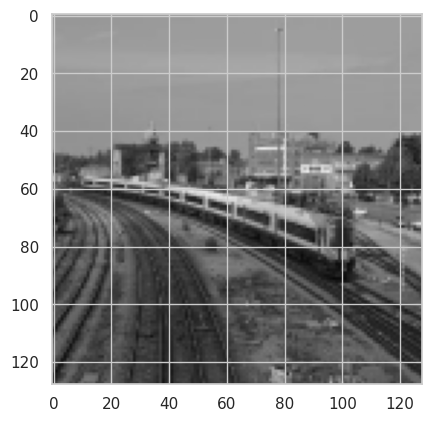

In [44]:
plt.imshow(img2[0])

In [20]:
# Load lại generator và discriminator
generator.load_weights("/kaggle/input/model/keras/default/1/generator_epoch_20.weights.h5")

generator.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 64, 64, 64)     │          3,136 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 32, 32, 128)    │        131,584 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 16, 16, 256)    │        525,312 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 8, 8, 384)      │      1,574,400 │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 4, 4, 384)      │      2,360,832 │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 2, 2, 512)      │      3,147,776 │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_6 (Sequential) │ (None, 4, 4, 512)      │      4,196,352 │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 4, 4, 896)      │              0 │ sequential_6[0][0],    │
│                           │                        │                │ sequential_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, 8, 8, 384)      │      5,506,560 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 8, 8, 768)      │              0 │ sequential_7[0][0],    │
│ (Concatenate)             │                        │                │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_8 (Sequential) │ (None, 16, 16, 256)    │      3,146,752 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 16, 16, 512)    │              0 │ sequential_8[0][0],    │
│ (Concatenate)             │                        │                │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_9 (Sequential) │ (None, 32, 32, 128)    │      1,049,088 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 32, 32, 256)    │              0 │ sequential_9[0][0],    │
│ (Concatenate)             │                        │                │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_10             │ (None, 64, 64, 64)     │        262,400 │ concatenate_3[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4        

 Total params: 21,970,243 (83.81 MB)

 Trainable params: 21,964,163 (83.79 MB)

 Non-trainable params: 6,080 (23.75 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


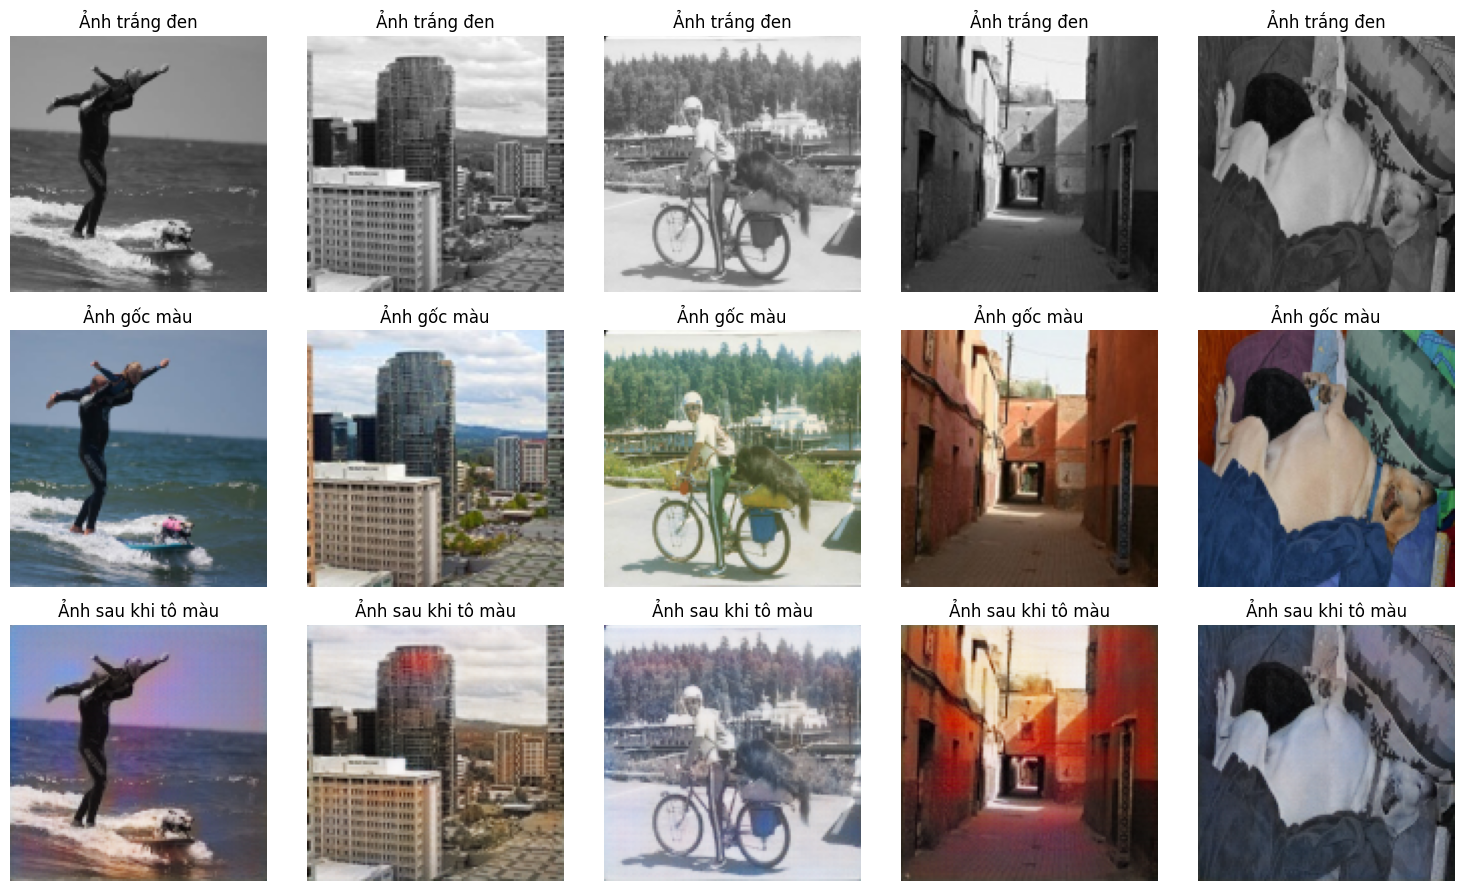

In [34]:
# Định nghĩa hàm load ảnh trắng đen (và chuyển sang 3 kênh nếu cần)
def load_grayscale_image_as_rgb(image_path, img_size=(128, 128)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh trắng đen
    img = cv2.resize(img, img_size)  # Resize về đúng kích thước model yêu cầu
    img = img.astype("float32") / 255.0  # Chuẩn hóa về [0,1]
    img_rgb = np.stack([img, img, img], axis=-1)  # Tạo ảnh 3 kênh
    img_rgb = np.expand_dims(img_rgb, axis=0)  # Thêm batch dimension
    return img_rgb

# Định nghĩa hàm load ảnh màu gốc
def load_color_image(image_path, img_size=(128, 128)):
    img = cv2.imread(image_path)  # Đọc ảnh màu (BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển sang RGB
    img = cv2.resize(img, img_size)  # Resize về đúng kích thước
    img = img.astype("float32") / 255.0  # Chuẩn hóa về [0,1]
    return img

# Lấy danh sách ảnh trong dataset
gray_folder = "/kaggle/input/image-colorization/gray"
color_folder = "/kaggle/input/image-colorization/color"

gray_images = sorted(os.listdir(gray_folder))  # Lấy danh sách ảnh
color_images = sorted(os.listdir(color_folder))  # Danh sách ảnh màu tương ứng

# Chọn ngẫu nhiên 5 ảnh
random_indices = random.sample(range(len(gray_images)), 5)
selected_gray_images = [gray_images[i] for i in random_indices]
selected_color_images = [color_images[i] for i in random_indices]

# Load 5 ảnh trắng đen và 5 ảnh màu gốc
bw_images = [load_grayscale_image_as_rgb(os.path.join(gray_folder, img)) for img in selected_gray_images]
color_images = [load_color_image(os.path.join(color_folder, img)) for img in selected_color_images]

# Tô màu ảnh bằng Generator
colorized_images = [generator.predict(bw_img)[0] for bw_img in bw_images]  # Lấy ảnh đã tô màu

# Hiển thị 5 ảnh trắng đen, 5 ảnh gốc, 5 ảnh đã tô màu
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for i in range(5):
    # Ảnh trắng đen (3 kênh)
    axes[0, i].imshow(bw_images[i][0])
    axes[0, i].set_title("Ảnh trắng đen")
    axes[0, i].axis("off")

    # Ảnh màu gốc
    axes[1, i].imshow(color_images[i])
    axes[1, i].set_title("Ảnh gốc màu")
    axes[1, i].axis("off")

    # Ảnh đã tô màu
    axes[2, i].imshow(colorized_images[i])
    axes[2, i].set_title("Ảnh sau khi tô màu")
    axes[2, i].axis("off")
    

plt.tight_layout()
plt.show()


In [5]:
import tensorflow as tf
import numpy as np
import cv2
import os
from PIL import Image
from scipy.linalg import sqrtm
from skimage.metrics import structural_similarity as ssim
from sewar.full_ref import vifp, msssim, psnr

# Load and preprocess images
def load_image(image_path, size=(256, 256)):
    image = Image.open(image_path).convert("RGB")
    image = image.resize(size)
    return np.array(image) / 255.0  # Normalize to [0,1]

# Compute FID score
def compute_fid(real_images, generated_images):
    real_mu, real_sigma = real_images.mean(axis=0), np.cov(real_images, rowvar=False)
    fake_mu, fake_sigma = generated_images.mean(axis=0), np.cov(generated_images, rowvar=False)
    diff = real_mu - fake_mu
    covmean = sqrtm(real_sigma @ fake_sigma)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return np.sum(diff**2) + np.trace(real_sigma + fake_sigma - 2 * covmean)

# Compute VIF score
def compute_vif(img1, img2):
    return vifp(img1, img2)

# Compute MS-SSIM score
def compute_msssim(img1, img2):
    return msssim(img1, img2)

# Compute PSNR score
def compute_psnr(img1, img2):
    return psnr(img1, img2)

# Evaluate image quality
def evaluate_image_quality(fid, vif_score, ms_ssim_score, psnr_score):
    print("\n===== Image Quality Evaluation =====")
    print(f"FID Score: {fid} (Lower is better)")
    print(f"VIF Score: {vif_score} (Higher is better)")
    print(f"MS-SSIM Score: {ms_ssim_score} (Higher is better)")
    print(f"PSNR Score: {psnr_score} (Higher is better)")
    
    if fid < 50 and vif_score > 0.5 and ms_ssim_score > 0.85 and psnr_score > 25:
        print("\nOverall: The image colorization quality is GOOD! ✅")
    else:
        print("\nOverall: The image colorization quality needs improvement! ❌")

# Example usage
if __name__ == "__main__":
    img1_path = "path_to_real_image.jpg"
    img2_path = "path_to_generated_image.jpg"

    img1 = load_image(img1_path)
    img2 = load_image(img2_path)
    
    fid = compute_fid(img1.flatten(), img2.flatten())
    vif_score = compute_vif(img1, img2)
    ms_ssim_score = compute_msssim(img1, img2)
    psnr_score = compute_psnr(img1, img2)
    
    evaluate_image_quality(fid, vif_score, ms_ssim_score, psnr_score)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/path_to_real_image.jpg'

In [4]:
!pip install sewar


  Preparing metadata (setup.py) ... done
  Created wheel for sewar: filename=sewar-0.4.6-py3-none-any.whl size=11421 sha256=84d3a8bf28ba1d4b0e6e1509af5e503a5e2c86450bcb804c65cdcb478f2a82fb
  Stored in directory: /root/.cache/pip/wheels/3f/af/02/9c6556ba287b62a945d737def09b8b8c35c9e1d82b9dfae84c
Successfully built sewar
